In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load MOSFET parameter and measurement data for Level 3
params_df = pd.read_csv('mosfet_params_level3_v11.csv')  
# Expected columns: MOSFET_ID, L, W, KP, VTO, PHI, GAMMA, THETA, ETA, LAMBDA, U0, UEXP, UCRIT, RD, RS, CBD, CBS, CGDO, CGSO, CGBO, CJ, CJSW, IS, PB, MJ, MJSW, TOX, XJ

measurements_df = pd.read_csv('measurements_level3_v11.csv')  
# Expected columns: MOSFET_ID, meas_index, VGS, VDS, ID

# Group measurements by MOSFET_ID, sort by meas_index, and flatten (VGS, VDS, ID) data into a vector
X_list = []
mosfet_ids = []

# Group by MOSFET_ID; assume each MOSFET has 561 measurement rows (same as Level 1: 11 VGS × 51 VDS points)
grouped = measurements_df.groupby('MOSFET_ID')
for mosfet_id, group in grouped:
    group_sorted = group.sort_values('meas_index')
    # Check if you have exactly 561 points
    if len(group_sorted) == 561:
        # Use VGS, VDS, and ID from each measurement
        # The input vector will have 561 * 3 = 1683 features
        features = group_sorted[['VGS', 'VDS', 'ID']].values.flatten()
        X_list.append(features)
        mosfet_ids.append(mosfet_id)

X = np.array(X_list)  # Shape: (num_devices, 561*3)

# Prepare target parameter y (only VTO)
params_df.set_index('MOSFET_ID', inplace=True)
y_list = []
for mosfet_id in mosfet_ids:
    row = params_df.loc[mosfet_id, ['VTO']].values
    y_list.append(row)
y = np.array(y_list).reshape(-1, 1)  # Shape: (num_devices, 1)

print("Input shape (X):", X.shape)
print("Target shape (y):", y.shape)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the inputs and outputs
input_scaler = StandardScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

output_scaler = StandardScaler()
y_train_scaled = output_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = output_scaler.transform(y_test.reshape(-1, 1))

Input shape (X): (55000, 1683)
Target shape (y): (55000, 1)


In [2]:
# Check for NaNs or extreme values in measurements
print("Measurements Summary:")
print(measurements_df[['VGS', 'VDS', 'ID']].describe())
print("NaNs in measurements:", measurements_df[['VGS', 'VDS', 'ID']].isna().sum())

# Check VTO range
print("\nVTO Summary:")
print(params_df['VTO'].describe())

# After predictions (Cell 5), inspect raw predictions vs. actual
print("\nSample Predictions vs Actual (First 5):")
for i in range(5):
    print(f"Predicted VTO: {predictions[i][0]:.4f}, Actual VTO: {y_test_original[i][0]:.4f}")

Measurements Summary:
                VGS           VDS            ID
count  3.085500e+07  3.085500e+07  3.085500e+07
mean   2.500000e+00  2.500000e+00  8.888448e-04
std    1.581139e+00  1.471960e+00  1.243522e-03
min    0.000000e+00  0.000000e+00 -6.017572e-14
25%    1.000000e+00  1.200000e+00  1.852107e-05
50%    2.500000e+00  2.500000e+00  3.801545e-04
75%    4.000000e+00  3.800000e+00  1.277251e-03
max    5.000000e+00  5.000000e+00  2.388971e-02
NaNs in measurements: VGS    0
VDS    0
ID     0
dtype: int64

VTO Summary:
count    55000.000000
mean         0.750452
std          0.260031
min          0.300024
25%          0.525091
50%          0.750559
75%          0.975181
max          1.199987
Name: VTO, dtype: float64

Sample Predictions vs Actual (First 5):


NameError: name 'predictions' is not defined

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear TensorFlow session to remove old model states
K.clear_session()

# Reset random seed for reproducibility
tf.random.set_seed(42)

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Determine the input dimension from the preprocessed data
input_dim = X_train_scaled.shape[1]
print("Input dimension:", input_dim)

# Build the model (same architecture as Level 1)
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Single output: VTO
])

# Compile the model for regression using MSE loss
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Input dimension: 1683


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       431,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,321 (1.80 MB)

 Trainable params: 472,321 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0084 - mae: 0.0530 - val_loss: 0.0143 - val_mae: 0.0775
Epoch 2/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0094 - mae: 0.0565 - val_loss: 0.0132 - val_mae: 0.0802
Epoch 3/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0064 - mae: 0.0464 - val_loss: 0.0073 - val_mae: 0.0567
Epoch 4/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0056 - mae: 0.0430 - val_loss: 0.0043 - val_mae: 0.0409
Epoch 5/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0062 - mae: 0.0455 - val_loss: 0.0181 - val_mae: 0.0866
Epoch 6/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070 - mae: 0.0477 - val_loss: 0.0105 - val_mae: 0.0642
Epoch 7/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0058 - mae: 0.0438 - val_loss: 0.0038 - val_mae: 0.0423
Epoch 8/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0068 - mae: 0.0467 - val_loss: 0.0075 - val_mae: 0.0584
Epoch 9/50
1100/1100 ━━━━━━━━━━━━━━━━━━━

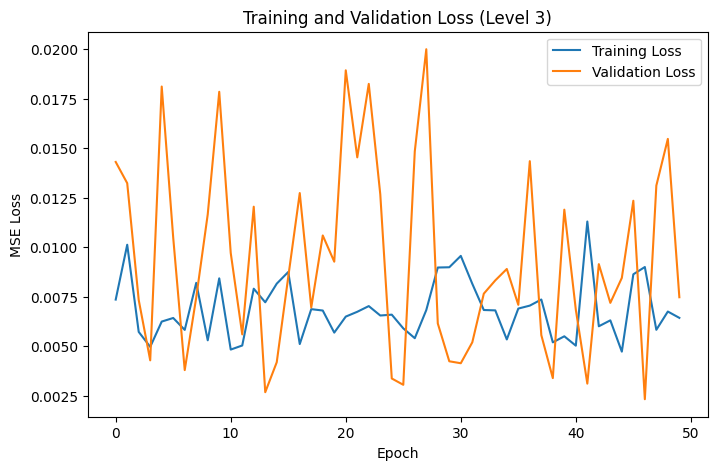

In [9]:
# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss (Level 3)')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of percentage errors
plt.figure(figsize=(10, 6))
plt.hist(percentage_errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage Errors (Level 3, Clipped)')
plt.grid(True, alpha=0.3)

# Add mean and median lines
mean_error = np.mean(percentage_errors)
median_error = np.median(percentage_errors)
plt.axvline(mean_error, color='red', linestyle='--', label=f'Mean = {mean_error:.2f}%')
plt.axvline(median_error, color='green', linestyle='--', label=f'Median = {median_error:.2f}%')
plt.legend()

plt.show()

In [10]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

# Define the VTO bounds for clipping based on physical constraints
VTO_MIN = 0.2  # Minimum VTO from params_df['VTO'].describe()
VTO_MAX = 1.3  # Maximum VTO from params_df['VTO'].describe()

# Function to compute and print metrics
def compute_metrics(y_true, y_pred, label):
    epsilon = 1e-10  # Small value to avoid division by zero
    percentage_errors = np.abs((y_pred - y_true) / (y_true + epsilon)) * 100
    mpe = np.mean(percentage_errors)
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"\n{label}:")
    print(f"Mean Percentage Error: {mpe:.2f}%")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.15f}")
    print(f"RMSE: {rmse:.10f}")
    return percentage_errors

# Get predictions
predictions_scaled = model.predict(X_test_scaled)
predictions_unclipped = output_scaler.inverse_transform(predictions_scaled)
y_test_original = output_scaler.inverse_transform(y_test_scaled)

# Total number of test samples
n_samples = len(y_test_original)

# Compute metrics without clipping
percentage_errors_unclipped = compute_metrics(y_test_original, predictions_unclipped, "Without Clipping")

# Clip predictions to physical VTO range
predictions_clipped = np.clip(predictions_unclipped, VTO_MIN, VTO_MAX)
percentage_errors_clipped = compute_metrics(y_test_original, predictions_clipped, "With Full Clipping")

# Clipping statistics
n_clipped_below = np.sum(predictions_unclipped < VTO_MIN)
n_clipped_above = np.sum(predictions_unclipped > VTO_MAX)
pct_clipped_below = (n_clipped_below / n_samples) * 100
pct_clipped_above = (n_clipped_above / n_samples) * 100

# Summary stats with clipping details
print("\nSummary Stats:")
print("True VTO min/max/mean:", y_test_original.min(), y_test_original.max(), y_test_original.mean())
print("Unclipped Predictions min/max/mean:", predictions_unclipped.min(), predictions_unclipped.max(), predictions_unclipped.mean())
print("Clipped Predictions min/max/mean:", predictions_clipped.min(), predictions_clipped.max(), predictions_clipped.mean())
print(f"\nClipping Details (out of {n_samples} samples):")
print(f"Values clipped below {VTO_MIN}: {n_clipped_below} ({pct_clipped_below:.2f}%)")
print(f"Values clipped above {VTO_MAX}: {n_clipped_above} ({pct_clipped_above:.2f}%)")

# Optional: Print sample predictions for inspection
print("\nSample Predictions vs Actual (First 5):")
for i in range(min(5, n_samples)):
    print(f"Predicted VTO (clipped): {predictions_clipped[i][0]:.4f}, Actual VTO: {y_test_original[i][0]:.4f}")

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Without Clipping:
Mean Percentage Error: 2.26%
R² Score: 0.9917
MSE: 0.000563856846516
RMSE: 0.0237456701

With Full Clipping:
Mean Percentage Error: 2.26%
R² Score: 0.9917
MSE: 0.000563856846516
RMSE: 0.0237456701

Summary Stats:
True VTO min/max/mean: 0.3000765296593027 1.1998131754122447 0.7545475447761918
Unclipped Predictions min/max/mean: 0.310105 1.2336448 0.7513733
Clipped Predictions min/max/mean: 0.310105 1.2336448 0.7513733

Clipping Details (out of 11000 samples):
Values clipped below 0.2: 0 (0.00%)
Values clipped above 1.3: 0 (0.00%)

Sample Predictions vs Actual (First 5):
Predicted VTO (clipped): 1.1648, Actual VTO: 1.1630
Predicted VTO (clipped): 0.3210, Actual VTO: 0.3409
Predicted VTO (clipped): 0.5866, Actual VTO: 0.5834
Predicted VTO (clipped): 0.5478, Actual VTO: 0.5638
Predicted VTO (clipped): 0.8893, Actual VTO: 0.8890


In [ ]:
# Save the model
model.save('mosfet_VTO_model_Level3_v11.keras')